In [38]:
%matplotlib inline

import os

import numpy as np
import pandas as pd
import geopandas as gpd
import fiona

from matplotlib import pyplot
from rasterio.plot import show
from rasterio import features


import rasterio

In [63]:
# our polygon exclusion shapefile
f = '/Users/d3y010/projects/mcmanamay/global_energy_potential/gis/species_ranges/botw_whooping_crane_mollweide.shp'

# read it into a geopandas data frame
gdf = gpd.read_file(f)

#### Select our field, we want it to be 1 for full excluded

In [64]:
gdf['value'] = 1

#### Only keep fields that we need; create fid field

In [65]:
gdf['fid'] = gdf.index
gdf = gdf[['fid', 'value', 'geometry']]

#### See the coordinate reference system

In [66]:
gdf.crs

<Projected CRS: PROJCS["Mollweide",GEOGCS["GCS_unknown",DATUM["WGS ...>
Name: Mollweide
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Mollweide
Datum: World Geodetic System 1984
- Ellipsoid: WGS_84
- Prime Meridian: Greenwich

#### Reproject to Albers

In [67]:
pdf = gdf.to_crs('+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs')

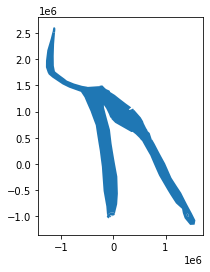

In [68]:
pdf.plot()

In [69]:
pdf.crs

<Projected CRS: +proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

#### Check out our template raster

In [31]:
template_raster = '/Users/d3y010/projects/cerf/suitability/_common/PNNL_Land_Mask_CONUS.img'


In [32]:
rast = rasterio.open(template_raster)

In [33]:
rast.meta

{'driver': 'HFA',
 'dtype': 'uint8',
 'nodata': 3.0,
 'width': 4693,
 'height': 2999,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["GCS_North_American_1983",DATUM["North_American_Datum_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["false_easting",0.0],PARAMETER["false_northing",0.0],PARAMETER["longitude_of_center",-96.0],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",37.5],UNIT["Meters",1.0]]'),
 'transform': Affine(1000.0, 0.0, -2405552.8355,
        0.0, -1000.0, 1609934.7995)}

### TODO:  Get proj4s for shapefile reprojection from raster template CRS

In [34]:
rast.crs

CRS.from_wkt('PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["GCS_North_American_1983",DATUM["North_American_Datum_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["false_easting",0.0],PARAMETER["false_northing",0.0],PARAMETER["longitude_of_center",-96.0],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",37.5],UNIT["Meters",1.0]]')

In [72]:
rast.close()

#### Convert the geodataframe to a raster using our template

In [80]:
def rasterize(geodataframe, template_raster, outras, field):
    
    with rasterio.open(template_raster) as src:
        kwargs = src.meta.copy()
        kwargs.update({
            'driver': 'GTiff',
            'compress': 'lzw'
        })
        
        #windows = src.block_windows(1)  
        
        with rasterio.open(outras, 'w', **kwargs) as dst:
            
            #for idx, window in windows:
                
            out_arr = src.read(1) #, window=window)
                
            # this is where we create a generator of geom, value pairs to use in rasterizing
            shapes = ((geom,value) for geom, value in zip(geodataframe.geometry, geodataframe[field]))

            burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=src.transform, all_touched=True)

            dst.write_band(1, burned) #, window=window)   

In [81]:
out_raster = '/Users/d3y010/Desktop/species.tif'

rasterize(pdf, template_raster, out_raster, 'value')

#### Examine new raster

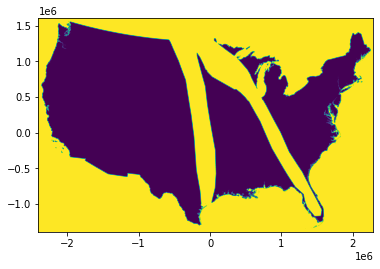

In [82]:
with rasterio.open(out_raster) as rast:
    show(rast)